This notebook loads the pickled dictionary with the presidents' raw and aggregated popularity, concatenates the raw popularity of each one, and saves all these data in a unique CSV file for sharing

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

from scipy.special import expit as logistic

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use('arviz-darkgrid')

In [3]:
all_presidents = pd.read_excel("../data/raw_popularity_presidents.xlsx", index_col=0, parse_dates=True)
all_presidents

president sondage  samplesize        method  approve_pr  \
1978-09-28       vge  Kantar        1040  face to face        60.0   
1978-10-17       vge    Ifop         949         phone        52.0   
1978-10-28       vge  Kantar         964  face to face        59.0   
1978-11-19       vge    Ifop        1069         phone        53.0   
1978-11-24       vge  Kantar         928  face to face        62.0   
...              ...     ...         ...           ...         ...   
2020-07-10    macron    Ifop        1018      internet        38.0   
2020-07-16    macron     BVA        1000      internet        39.0   
2020-07-16    macron    Ifop         974      internet        37.0   
2020-07-22    macron  Harris         960      internet        50.0   
2020-08-05    macron   Elabe        1002      internet        39.0   

            disapprove_pr  
1978-09-28           33.0  
1978-10-17           35.0  
1978-10-28           34.0  
1978-11-19           37.0  
1978-11-24           33.0  
...                   ...  
2020-07-10           62.0  
2020-07-16           61.0  
2020-07-16           63.0  
2020-07-22           50.0  
2020-08-05           56.0  

[1875 rows x 6 columns]

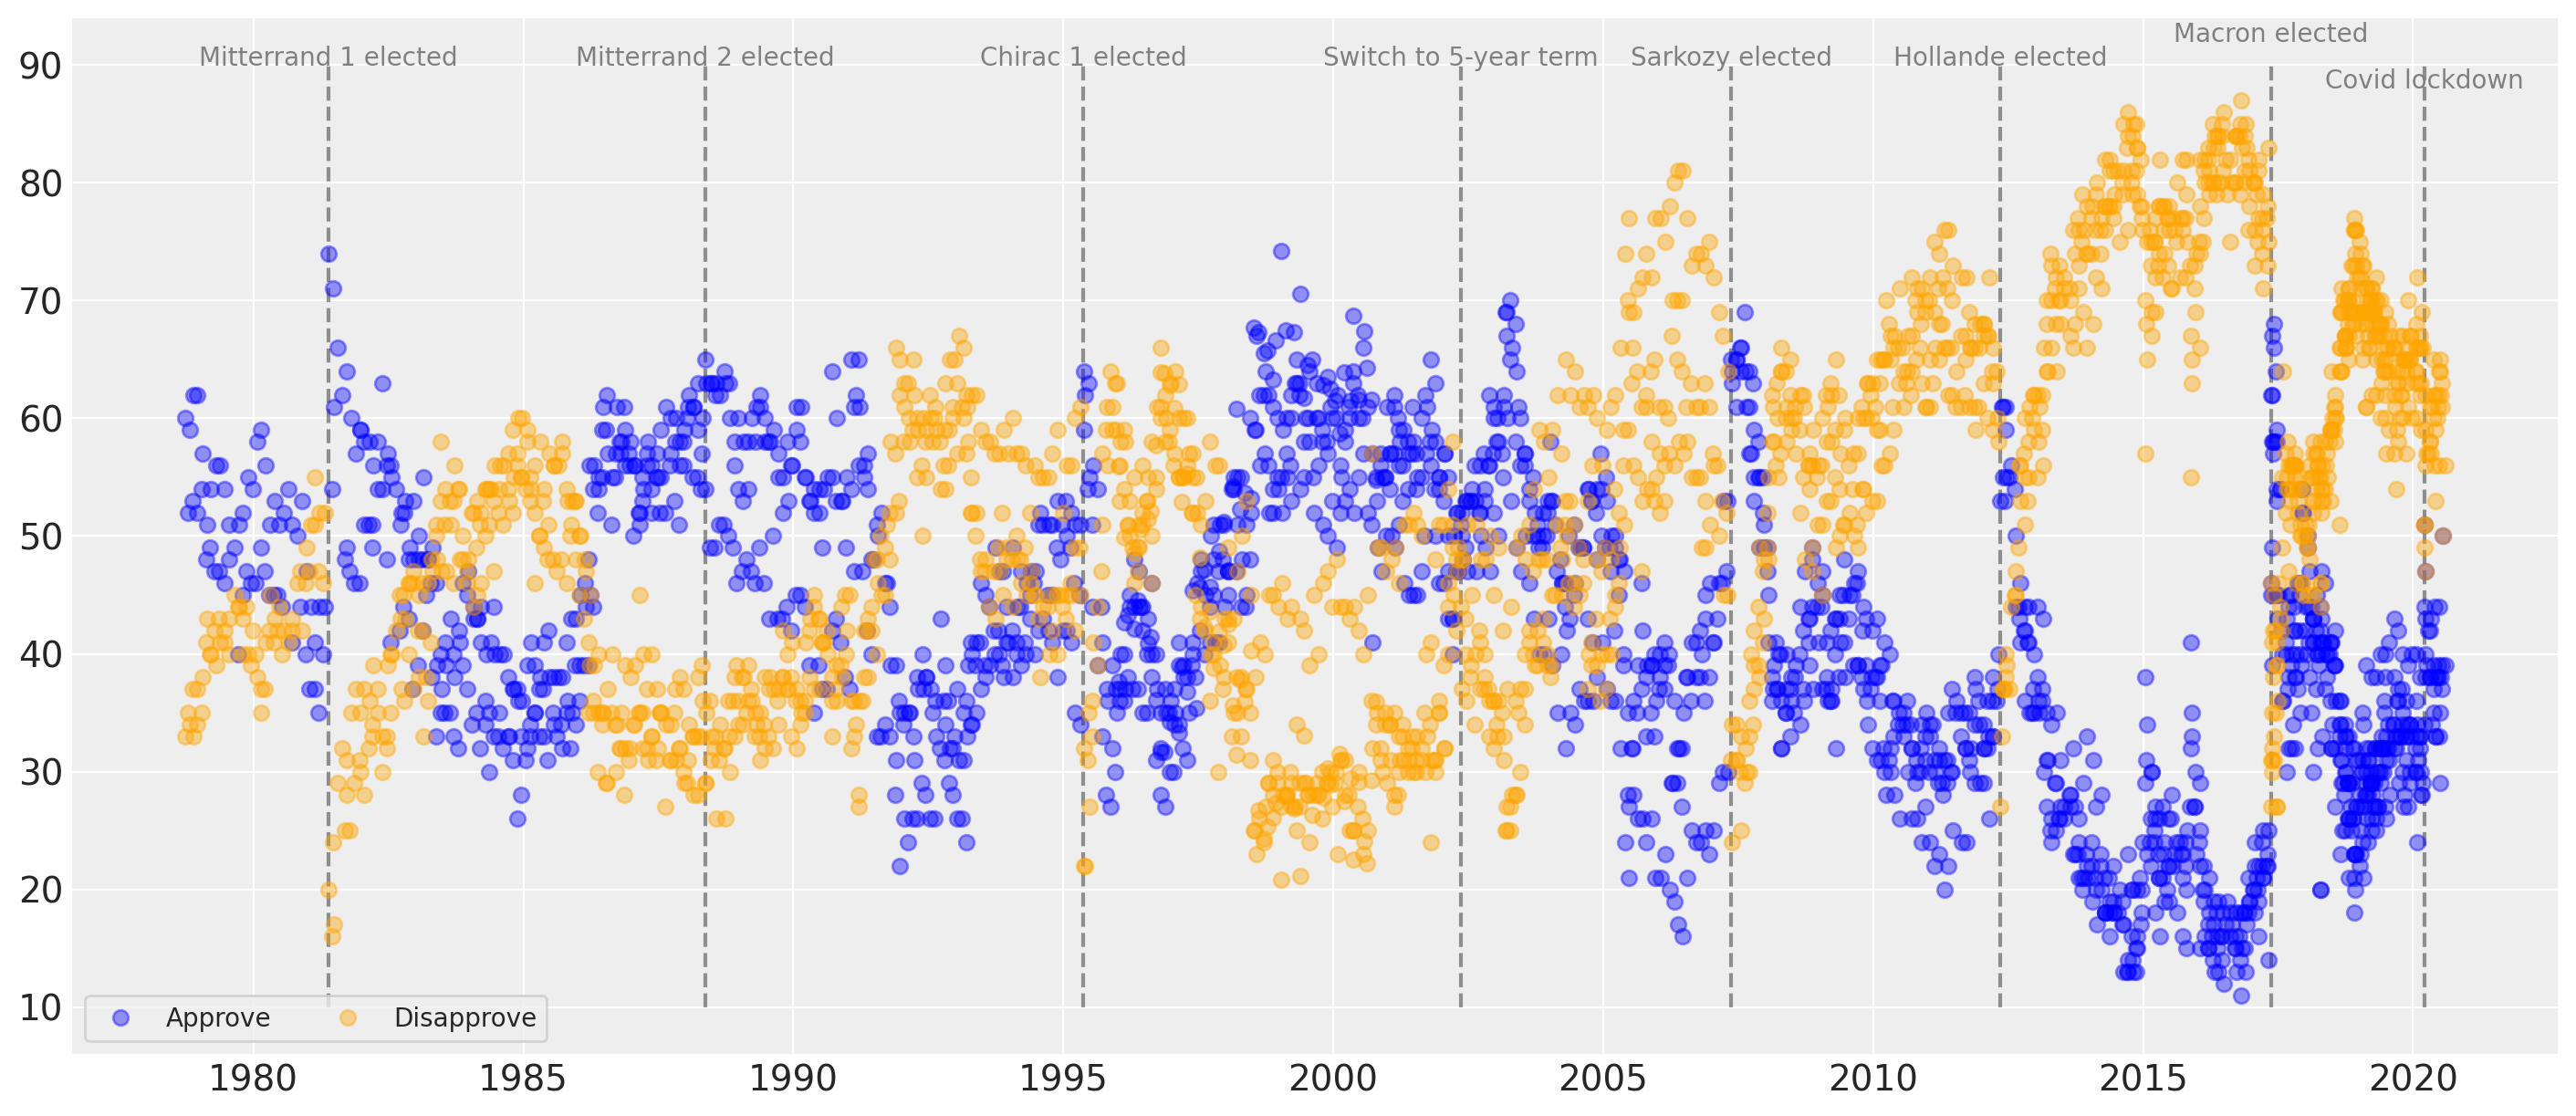

In [4]:
_, ax = plt.subplots(1, 1, figsize=(14, 6))

ax.plot(all_presidents.index, all_presidents.approve_pr, "ob", label="Approve", alpha=0.4)
ax.plot(all_presidents.index, all_presidents.disapprove_pr, "o", color="orange", label="Disapprove", alpha=0.4)

ax.vlines(pd.to_datetime("1981-05-25"), 10, 90, "k", "--", alpha=0.4)
ax.text(pd.to_datetime("1981-05-25"), 90, "Mitterrand 1 elected", fontsize=10, color="grey", horizontalalignment="center")

ax.vlines(pd.to_datetime("1988-05-16"), 10, 90, "k", "--", alpha=0.4)
ax.text(pd.to_datetime("1988-05-16"), 90, "Mitterrand 2 elected", fontsize=10, color="grey", horizontalalignment="center")

ax.vlines(pd.to_datetime("1995-05-18"), 10, 90, "k", "--", alpha=0.4)
ax.text(pd.to_datetime("1995-05-18"), 90, "Chirac 1 elected", fontsize=10, color="grey", horizontalalignment="center")

ax.vlines(pd.to_datetime("2002-05-14"), 10, 90, "k", "--", alpha=0.4)
ax.text(pd.to_datetime("2002-05-14"), 90, "Switch to 5-year term", fontsize=10, color="grey", horizontalalignment="center")

ax.vlines(pd.to_datetime("2007-05-16"), 10, 90, "k", "--", alpha=0.4)
ax.text(pd.to_datetime("2007-05-16"), 90, "Sarkozy elected", fontsize=10, color="grey", horizontalalignment="center")

ax.vlines(pd.to_datetime("2012-05-11"), 10, 90, "k", "--", alpha=0.4)
ax.text(pd.to_datetime("2012-05-11"), 90, "Hollande elected", fontsize=10, color="grey", horizontalalignment="center")

ax.vlines(pd.to_datetime("2017-05-17"), 10, 90, "k", "--", alpha=0.4)
ax.text(pd.to_datetime("2017-05-17"), 92, "Macron elected", fontsize=10, color="grey", horizontalalignment="center")

ax.vlines(pd.to_datetime("2020-03-17"), 10, 90, "k", "--", alpha=0.4)
ax.text(pd.to_datetime("2020-03-17"), 88, "Covid lockdown", fontsize=10, color="grey", horizontalalignment="center")

plt.legend(fontsize=10, ncol=2, loc="lower left", frameon=True);

In [5]:
# restrict data to after the switch to 5-year term
#d = all_presidents.loc[all_presidents.index >= pd.to_datetime("2002-05-05")]
# restrict data to Macron
d = all_presidents[all_presidents.president == "macron"]

# convert to proportions
d[["approve_pr", "disapprove_pr"]] = d[["approve_pr", "disapprove_pr"]].copy() / 100
d = d.rename(columns={"approve_pr": "p_approve", "disapprove_pr": "p_disapprove"})

# raw monthly average to get fixed time intervals
d = d[["samplesize", "p_approve", "p_disapprove"]].resample("M").mean()

# convert to nbr of successes
d["N_approve"] = d.samplesize * d["p_approve"]
d["N_disapprove"] = d.samplesize * d["p_disapprove"]
d[["N_approve", "N_disapprove"]] = d[["N_approve", "N_disapprove"]].round().astype(int)

# compute total trials
d["N_total"] = d.N_approve + d.N_disapprove
d

/Users/alex_andorra/opt/anaconda3/envs/elections-models/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


samplesize  p_approve  p_disapprove  N_approve  N_disapprove  \
2017-05-31  1122.300000   0.543000      0.353000        609           396   
2017-06-30  1721.727273   0.557273      0.359091        959           618   
2017-07-31  1195.600000   0.462000      0.448000        552           536   
2017-08-31  1028.666667   0.383333      0.561667        394           578   
2017-09-30  1134.000000   0.390000      0.538750        442           611   
2017-10-31  1156.625000   0.387500      0.555000        448           642   
2017-11-30  1124.625000   0.413750      0.518750        465           583   
2017-12-31  1296.250000   0.492500      0.467500        638           606   
2018-01-31  1123.666667   0.438889      0.498889        493           561   
2018-02-28  1122.625000   0.400000      0.535000        449           601   
2018-03-31  1172.000000   0.393333      0.558333        461           654   
2018-04-30  1110.727273   0.372727      0.520909        414           579   
2018-05-31  1009.600000   0.404000      0.556000        408           561   
2018-06-30  1115.875000   0.378750      0.582500        423           650   
2018-07-31  1138.857143   0.360000      0.601429        410           685   
2018-08-31  1017.625000   0.328750      0.636250        335           647   
2018-09-30  1107.400000   0.296000      0.678000        328           751   
2018-10-31  1106.272727   0.282727      0.684545        313           757   
2018-11-30  1122.500000   0.261000      0.711000        293           798   
2018-12-31  1133.500000   0.253750      0.730000        288           827   
2019-01-31  1098.545455   0.269091      0.710000        296           780   
2019-02-28  1084.300000   0.297000      0.675000        322           732   
2019-03-31  1080.230769   0.296923      0.683077        321           738   
2019-04-30  1102.666667   0.293333      0.677778        323           747   
2019-05-31  1160.555556   0.307778      0.673333        357           781   
2019-06-30  1092.666667   0.336667      0.643333        368           703   
2019-07-31   998.666667   0.320000      0.640000        320           639   
2019-08-31   974.800000   0.362000      0.634000        353           618   
2019-09-30  1111.625000   0.347500      0.611250        386           679   
2019-10-31  1112.750000   0.336250      0.631250        374           702   
2019-11-30  1104.875000   0.326250      0.637500        360           704   
2019-12-31  1131.333333   0.333333      0.650000        377           735   
2020-01-31  1129.000000   0.335714      0.644286        379           727   
2020-02-29  1096.777778   0.307778      0.652222        338           715   
2020-03-31  1096.888889   0.405556      0.553333        445           607   
2020-04-30  1174.400000   0.406000      0.582000        477           684   
2020-05-31  1126.428571   0.371429      0.594286        418           669   
2020-06-30  1124.714286   0.362857      0.612857        408           689   
2020-07-31   991.200000   0.398000      0.602000        394           597   
2020-08-31  1002.000000   0.390000      0.560000        391           561   

            N_total  
2017-05-31     1005  
2017-06-30     1577  
2017-07-31     1088  
2017-08-31      972  
2017-09-30     1053  
2017-10-31     1090  
2017-11-30     1048  
2017-12-31     1244  
2018-01-31     1054  
2018-02-28     1050  
2018-03-31     1115  
2018-04-30      993  
2018-05-31      969  
2018-06-30     1073  
2018-07-31     1095  
2018-08-31      982  
2018-09-30     1079  
2018-10-31     1070  
2018-11-30     1091  
2018-12-31     1115  
2019-01-31     1076  
2019-02-28     1054  
2019-03-31     1059  
2019-04-30     1070  
2019-05-31     1138  
2019-06-30     1071  
2019-07-31      959  
2019-08-31      971  
2019-09-30     1065  
2019-10-31     1076  
2019-11-30     1064  
2019-12-31     1112  
2020-01-31     1106  
2020-02-29     1053  
2020-03-31     1052  
2020-04-30     1161  
2020-05-31     1087  
2020-06-30     1097

In [6]:
def dates_to_idx(timelist):
    """Convert datetimes to numbers in reference to a given date. Useful for posterior predictions."""
    
    reference_time = timelist[0]
    t = (timelist - reference_time) / np.timedelta64(1, "M")
    
    return np.asarray(t)

In [7]:
time = dates_to_idx(d.index)
time

array([ 0.        ,  0.98564652,  2.00414793,  3.02264934,  4.00829586,
        5.02679726,  6.01244379,  7.03094519,  8.0494466 ,  8.96938335,
        9.98788476, 10.97353128, 11.99203269, 12.97767921, 13.99618062,
       15.01468203, 16.00032855, 17.01882996, 18.00447648, 19.02297788,
       20.04147929, 20.96141605, 21.97991745, 22.96556397, 23.98406538,
       24.9697119 , 25.98821331, 27.00671472, 27.99236124, 29.01086265,
       29.99650917, 31.01501058, 32.03351198, 32.98630362, 34.00480503,
       34.99045155, 36.00895296, 36.99459948, 38.01310089, 39.03160229])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [time_structure_rotated_, eta, ls, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 227 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


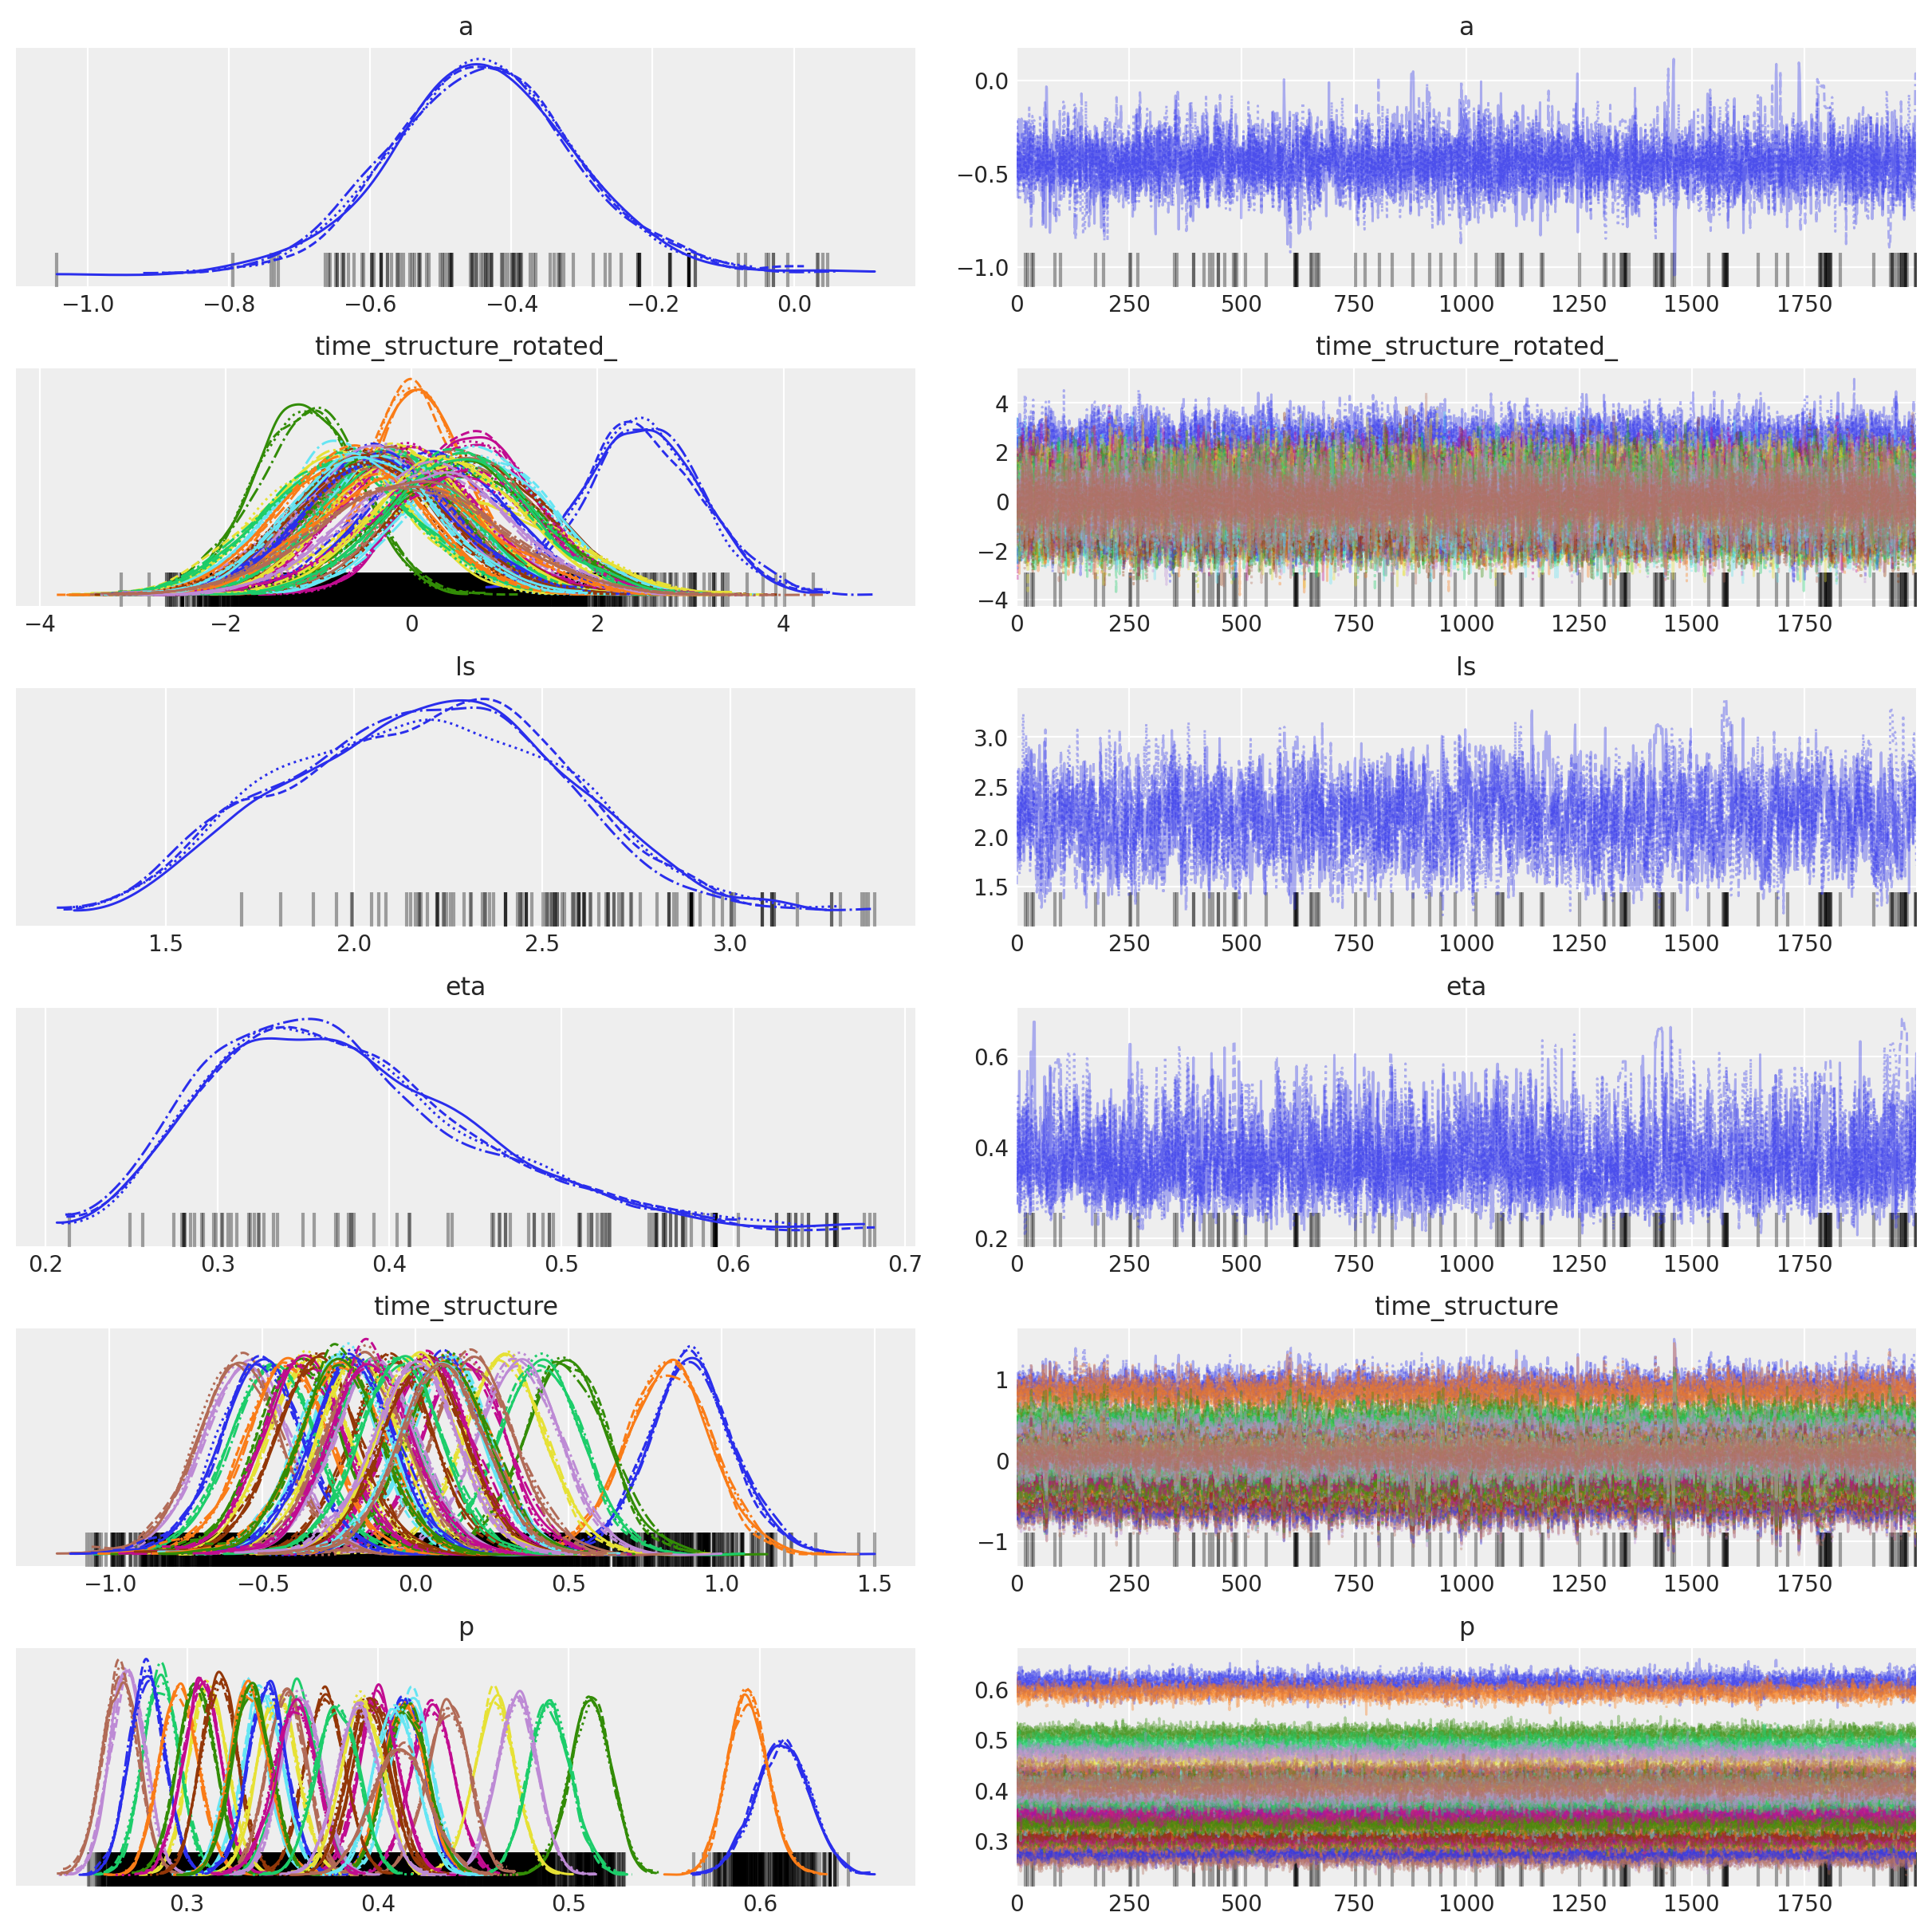

In [62]:
with pm.Model() as raw_latent_gp:
    
    # intercept on logit scale
    a = pm.Normal("a", -0.1, 1.)
    
    # informative lengthscale prior
    ls = pm.Gamma("ls", alpha=2, beta=1)
    # informative, positive normal prior on the period
    eta = pm.HalfNormal("eta", 5)
    cov = eta ** 2 * pm.gp.cov.ExpQuad(1, ls)

    # mean is 0 by default
    gp = pm.gp.Latent(cov_func=cov)

    # evaluate GP at time points
    f_time = gp.prior("f_time", X=time[:, None])

    # logit link and Binomial likelihood
    p = pm.Deterministic("p", pm.math.invlogit(a + f_time))
    y = pm.Binomial("y", p=p, n=d.N_total, observed=d.N_approve)

    trace = pm.sample(tune=2000, draws=2000, return_inferencedata=True)
    
az.plot_trace(trace, compact=True);

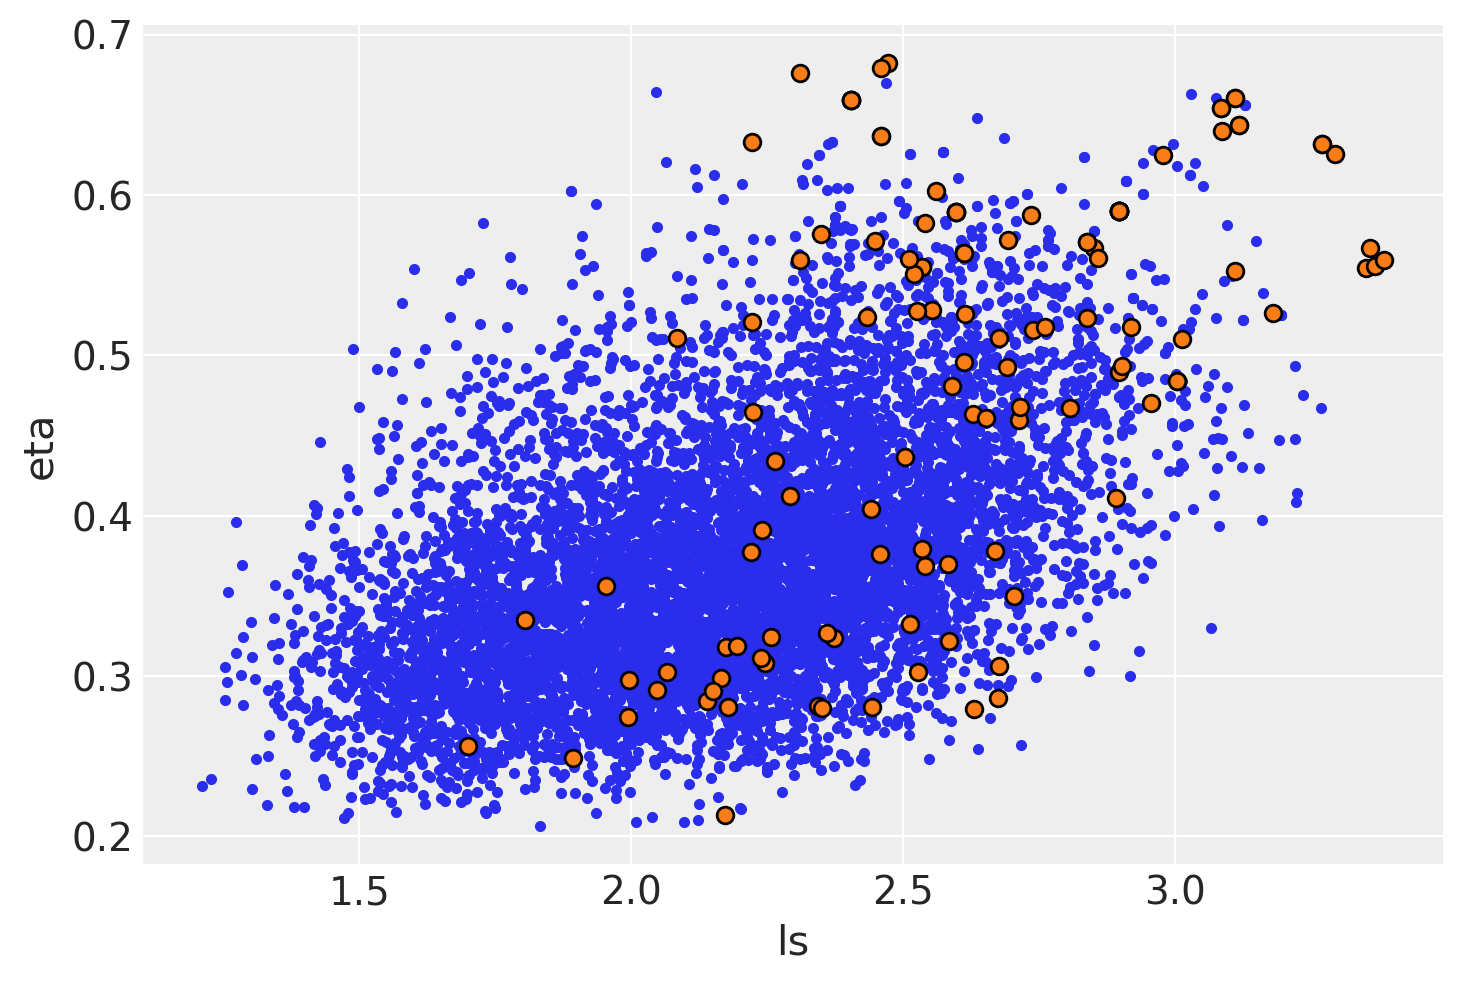

In [63]:
az.plot_pair(trace, var_names=["ls", "eta"], divergences=True);

In [76]:
tnew = np.linspace(-5, 60, 200)[:,None]
with raw_latent_gp:
    fnew = gp.conditional("fnew3", Xnew=tnew)
    ppc = pm.sample_posterior_predictive(trace.posterior, samples=1000, var_names=["a", "fnew3"])
    az.from_pymc3_predictions(
        ppc, idata_orig=trace, inplace=True
    )
    
pred = trace.predictions

/Users/alex_andorra/opt/anaconda3/envs/elections-models/lib/python3.8/site-packages/pymc3/sampling.py:1617: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


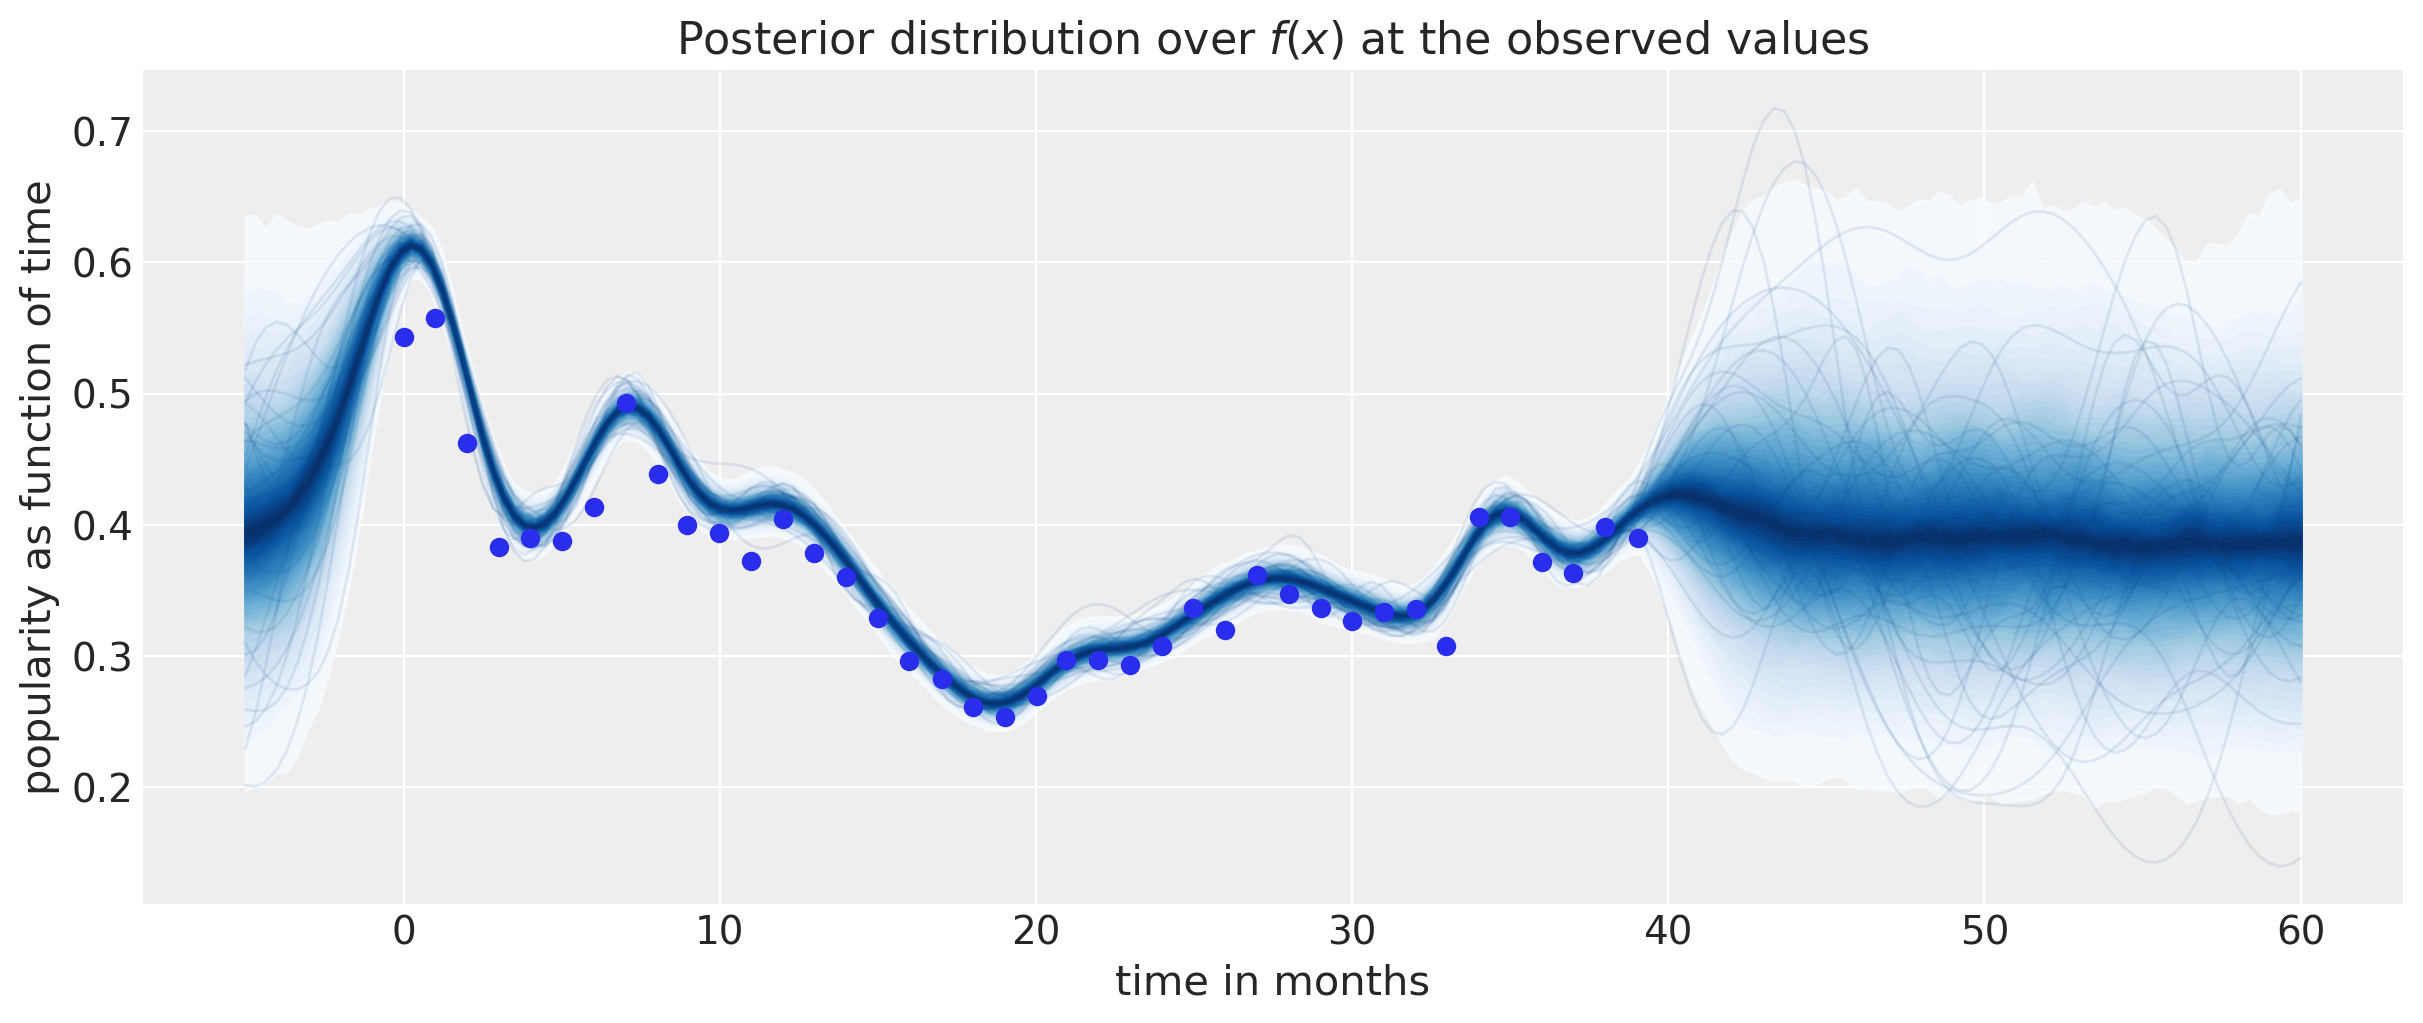

In [100]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
pp_prop = logistic(pred["a"] + pred["fnew3"]).stack(sample=("chain", "draw")).data.T
pm.gp.util.plot_gp_dist(ax, pp_prop, tnew, plot_samples=True, palette="Blues")

# plot the data
plt.plot(
    time,
    d.p_approve.values,
    "o",
)

# axis labels and title
plt.xlabel("time in months")
plt.ylabel("popularity as function of time")
plt.title("Posterior distribution over $f(x)$ at the observed values");

Priors are very important to fit GPs properly, so let's spend some time thinking about our priors for a more refined model of the popularity of the president. We start by the priors for the lengthscale and period parameters:
- `ls_trend`: The lengthscale of the long term trend. It has a wide prior with most of the mass between 1 to 3 years.
- `ls_med`: This is the lengthscale for the short to medium long variations. This prior has most of its mass below 2 years.
- `scale_mixture_rate` of the Rational Quadratic kernel: It is equivalent to using a combination of Exponential Quadratic kernels with different length scales. As the scale mixture rate approaches infinity, the kernel becomes exactly equivalent to the Exponential Quadratic Kernel. We center the prior for this parameter around 3, since we’re expecting that there is some more variation than could be explained by an exponentiated quadratic kernel.
- `period` of the semi-periodic component: We don't have a strong prior on this, so we'll center the period at one year, with the possibility for short-term seasonality as well as longer seasonality.
- `ls_period`: The smoothness of the semi-periodic component. It controls how “sinusoidal” the periodicity is. The plot of the data shows that seasonality is quite far from a sine wave, so we use a Gamma whose mode is at 2, and a relatively large variance.
- `ls_period_decay`: The periodic decay. The smaller this parameter, the faster the periodicity goes away. I suspect the seasonality of popularity goes away quite quickly, so let's put most of the prior mass between 6 months and 2 years.

If you're a bit lost, that's quite normal: parameters for GPs are not easily interpretable so it takes some time to develop intuition about them -- all the more so because the Gamma distribution is very flexible, so it can take _a lot_ of different shapes. Here are good educational ressources to think about priors in the context of GPs:
- PyMC3's CO2 at Mauna Loa [example notebook](https://docs.pymc.io/notebooks/GP-MaunaLoa.html).
- PyMC3's notebook for [mean and covariance functions](https://docs.pymc.io/notebooks/GP-MeansAndCovs.html).
- PyMC4's notebook for [mean and covariance functions](https://github.com/pymc-devs/pymc4/blob/master/notebooks/GP-Kernels.ipynb).
- Michael Betancourt's ["Probabilistic Building Blocks"](https://betanalpha.github.io/assets/case_studies/probability_densities.html#25_the_gamma_family) case-study.

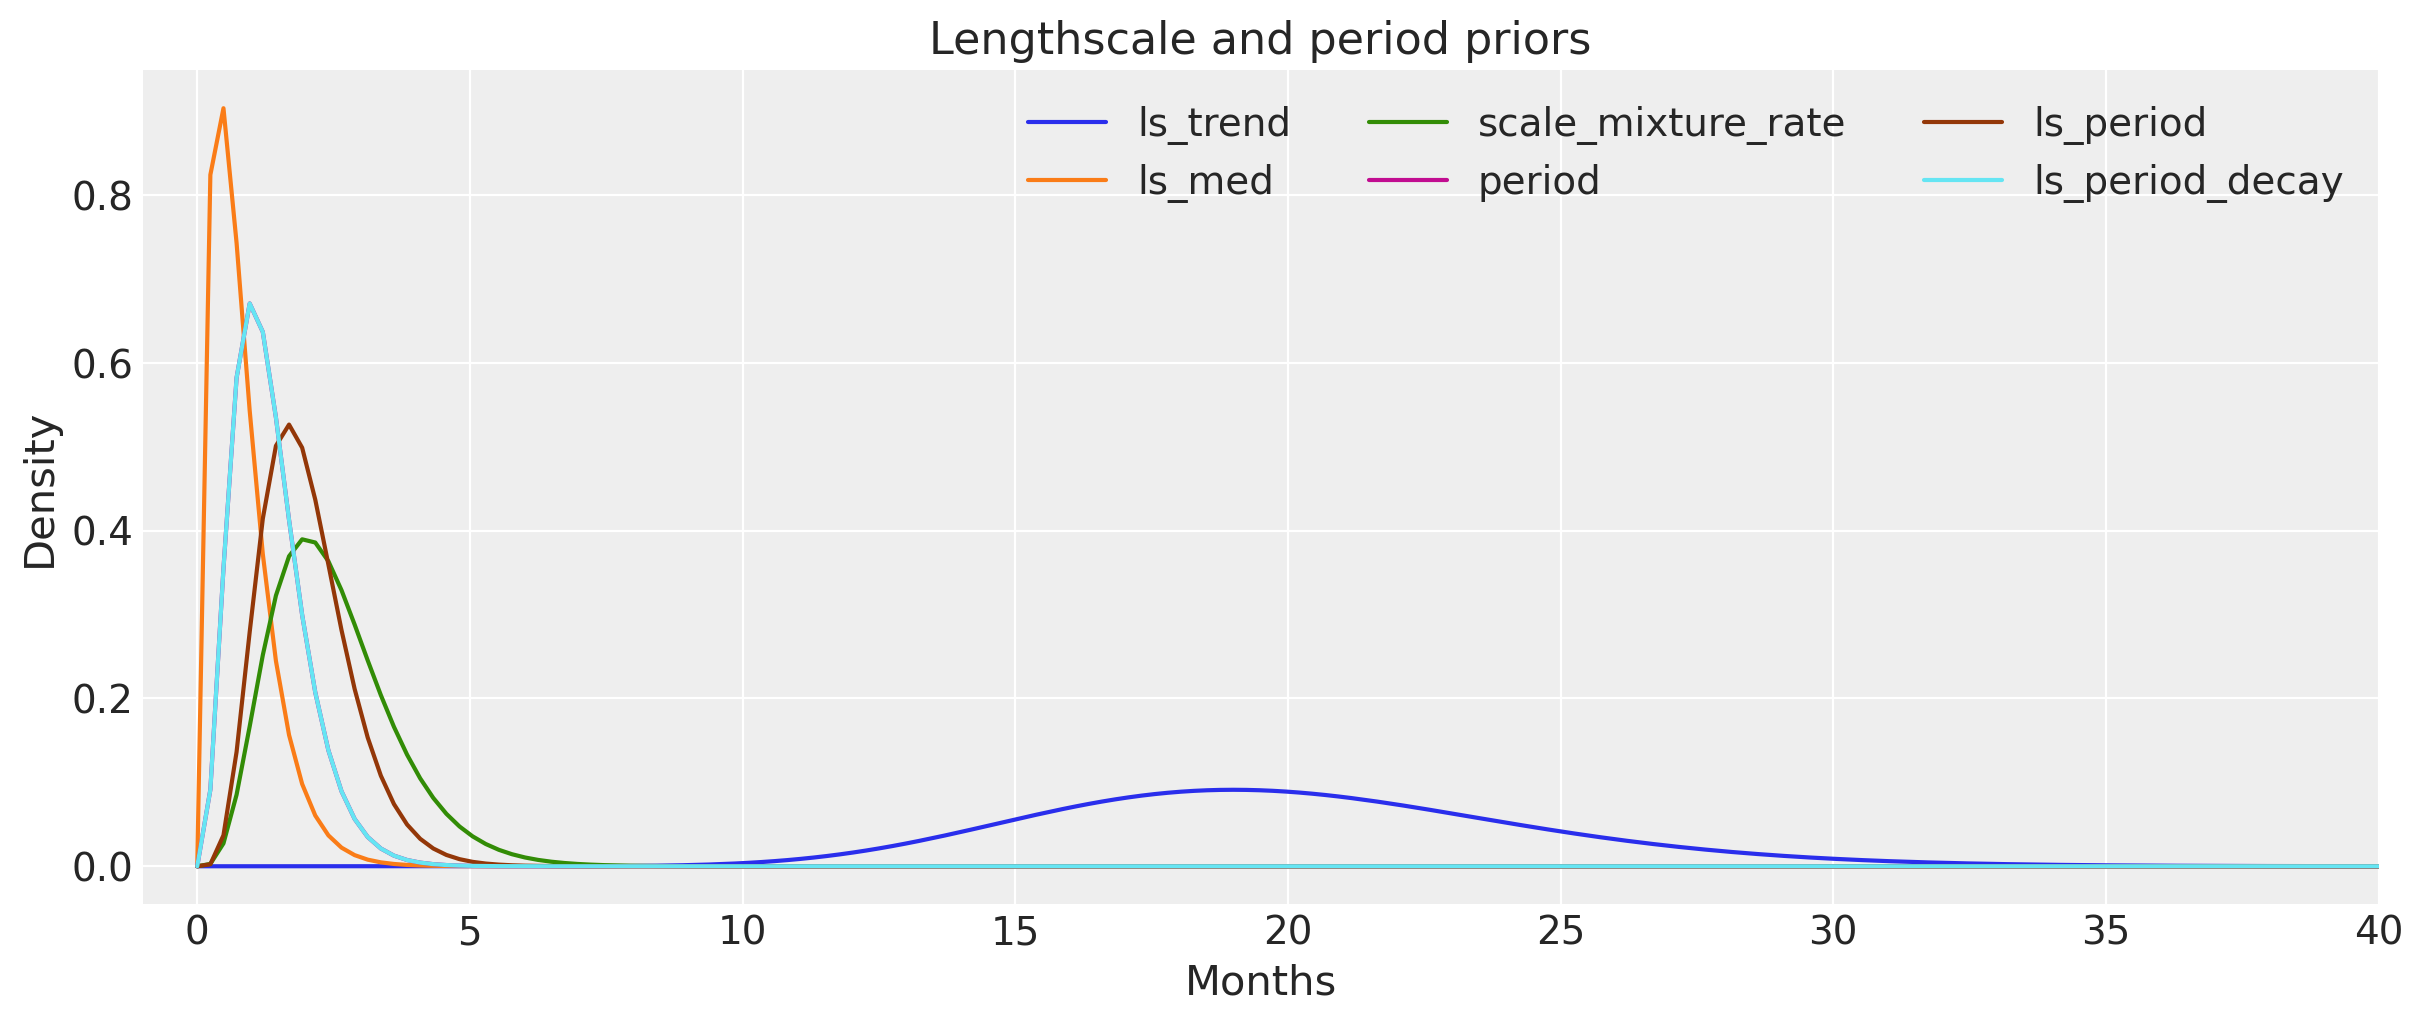

In [28]:
x = np.linspace(0, 120, 500)
priors = [
    ("ls_trend",  pm.Gamma.dist(alpha=20, beta=1)),
    ("ls_med", pm.Gamma.dist(alpha=2,  beta=2.5)),
    ("scale_mixture_rate", pm.Gamma.dist(alpha=5,  beta=2)),
    ("period", pm.Gamma.dist(alpha=4,  beta=3)),
    ("ls_period", pm.Gamma.dist(alpha=6,  beta=3)),
    ("ls_period_decay", pm.Gamma.dist(alpha=4, beta=3)),
]
#color = plt.cm.cividis(np.linspace(0, 1, len(priors)))

fig = plt.figure(figsize=(12, 5))

for i, prior in enumerate(priors):
    plt.plot(x, np.exp(prior[1].logp(x).eval()), label=prior[0])

plt.xlim((-1, 40))
plt.xlabel("Months")
plt.ylabel("Density")
plt.title("Lengthscale and period priors")
plt.legend(ncol=3);

Now we have to think about priors for our scale parameters: `amplitude_trend` (the scale of the long term trend), `amplitude_med` (the scale of the short to medium term component), and `amplitude_per` (the scale of the semi-periodic component). We don't have a lot of prior information about these parameters, so let's choose a weakly informative prior:

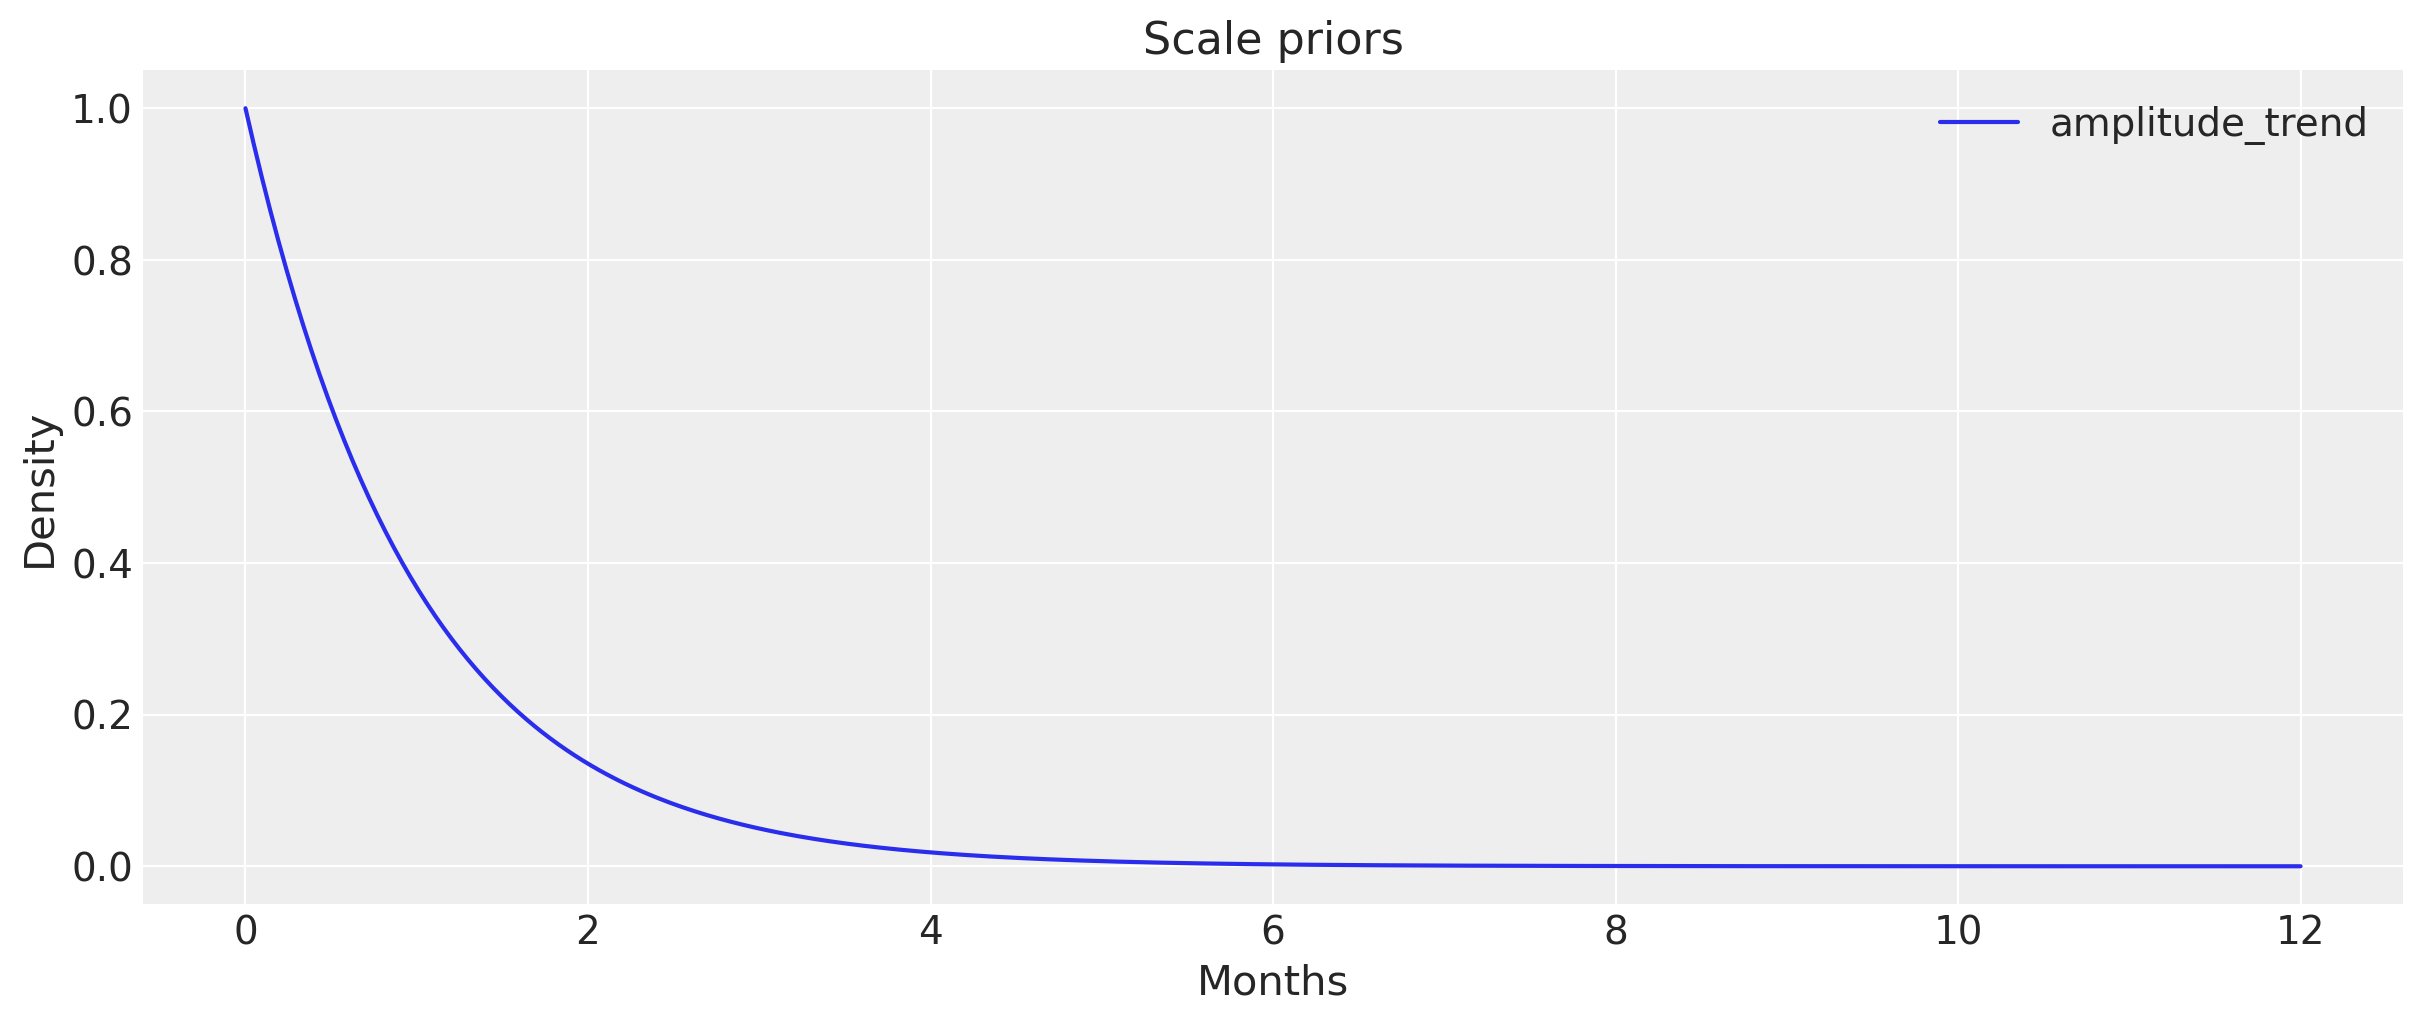

In [33]:
x = np.linspace(0, 12, 500)
priors = [
    ("amplitude_trend", pm.Exponential.dist(1)),
]

fig = plt.figure(figsize=(12, 5))

for i, prior in enumerate(priors):
    plt.plot(x, np.exp(prior[1].logp(x).eval()), label=prior[0])

plt.xlabel("Months")
plt.ylabel("Density")
plt.title("Scale priors")
plt.legend();

Finally, let's pick a prior for our `baseline` parameter, i.e the intercept of our Gaussian Process regression. In other words, this will be the mean function of our GP -- the value it reverts to when data start lacking. There we have quite a lot of information: 50% popularity is historically quite high for a French president (just take a look at the whole dataset we loaded at the beginning of the NB), so keeping the mean at zero is sub-optimal -- remember that `baseline` lives on the logit scale, so a prior centered at 0 means a prior centered at $logistic(0) = 0.5$ on the outcome space. 

We can do better: based on our domain knowledge, we expect most president to have a baseline popularity between 20% and 50% -- in other words, French people rarely love their presidents but often _really_ dislike them. $Normal(-0.7, 0.5)$ looks reasonable in that regard: it expects 95% of the probability mass to be between -1.7 and 0.3, i.e $logistic(-1.7) = 15\%$ and $logistic(0.3) = 57\%$, with a mean approval of $logistic(-0.7) = 33\%$:

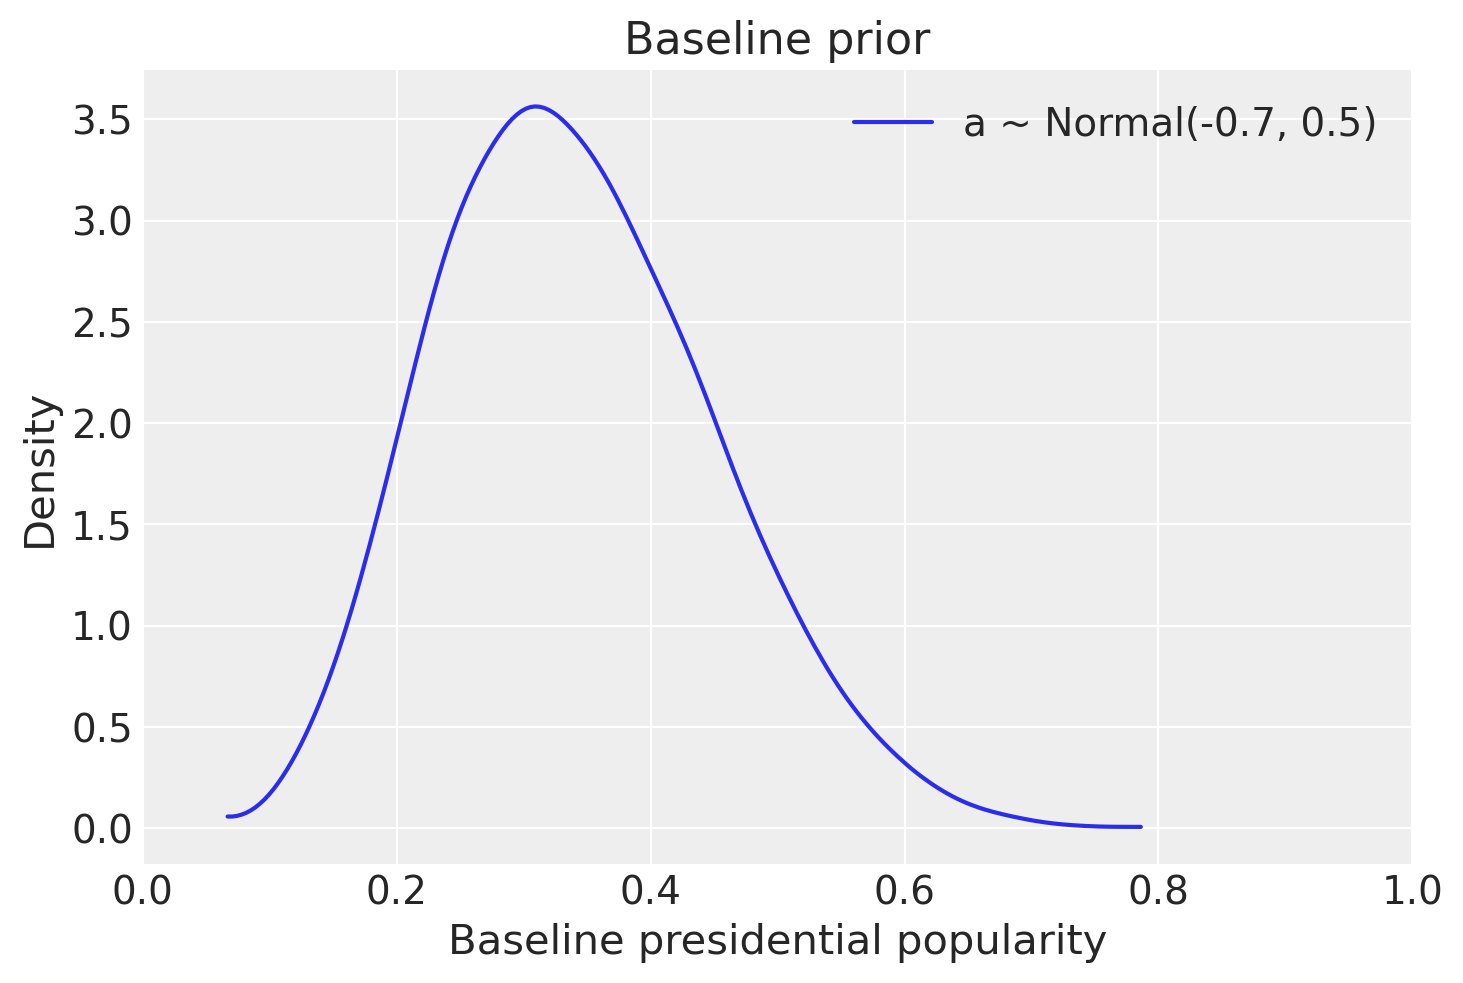

In [47]:
ax = az.plot_kde(
    logistic(pm.Normal.dist(-0.7, 0.5).random(size=20_000)), label="a ~ Normal(-0.7, 0.5)",
)
ax.set_xlim((0, 1))
ax.set_xlabel("Baseline presidential popularity")
ax.set_ylabel("Density")
ax.set_title("Baseline prior");

In [ ]:
with pm.Model() as finer_latent_gp:
    # intercept on logit scale
    baseline = pm.Normal("baseline", -0.7, 0.5)
    
    # long term trend
    amplitude_trend = pm.Exponential("amplitude_trend", 1.)
    ls_trend = pm.Gamma("ls_trend", alpha=20, beta=1)
    
    cov_trend = amplitude_trend**2 * pm.gp.cov.Matern52(1, ls_trend)
    gp_trend = pm.gp.Latent(cov_func=cov_trend)
    
    # small/medium term irregularities
    amplitude_med = pm.Exponential("amplitude_med", beta1.)
    ls_med = pm.Gamma("ls_med", alpha=2,  beta=2.5)
    scale_mixture_rate = pm.Gamma("scale_mixture_rate", alpha=5,  beta=2) 
    
    cov_medium = amplitude_med**2 * pm.gp.cov.RatQuad(1, alpha=scale_mixture_rate, ls=ls_med)
    gp_medium = pm.gp.Latent(cov_func=cov_medium)
    
    # semi-periodic component
    amplitude_per = pm.Exponential("amplitude_per", 1.)
    period  = pm.Gamma("period", alpha=4,  beta=3)
    ls_period = pm.Gamma("ls_period ", alpha=6,  beta=3)
    ls_period_decay = pm.Gamma("ls_period_decay", alpha=4, beta=3)
    
    cov_seasonal = amplitude_per**2 * pm.gp.cov.Periodic(1, period, ls_period) * pm.gp.cov.Matern52(1, ls_period_decay)
    gp_seasonal = pm.gp.Latent(cov_func=cov_seasonal)

    # The Gaussian process is a sum of these three components
    gp = gp_trend + gp_medium + gp_seasonal

    # evaluate GP at time points
    f_time = gp.prior("f_time", X=time[:, None])

    # logit link and Binomial likelihood
    p = pm.Deterministic("p", pm.math.invlogit(baseline + f_time))
    y = pm.Binomial("y", p=p, n=d.N_total, observed=d.N_approve)

    trace = pm.sample(tune=2000, draws=2000, return_inferencedata=True)
    
az.plot_trace(trace, compact=True);